<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 1
</font>
<br/>		
<font size=4>
<br/>
</div>

# Personal Data

In [ ]:
# Set your student number
student_number = 99101279
Name = 'AmirReza'
Last_Name = 'Imani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [ ]:
!pip install torchvision
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing Libraries

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [ ]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [ ]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [ ]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class

- **Hint**:  You can use `plt.subplots` for visualization

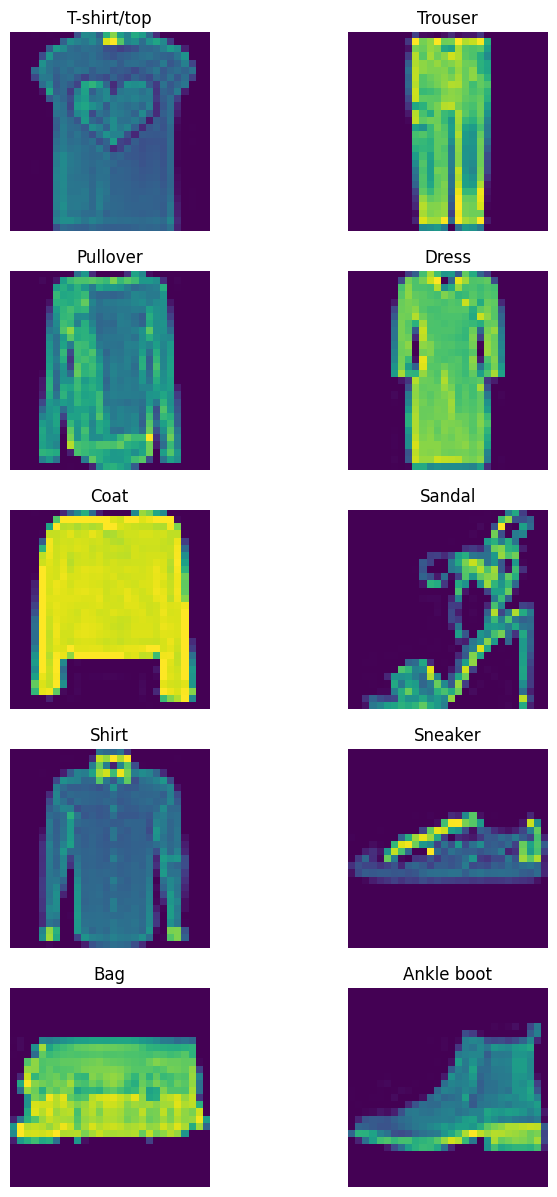

In [ ]:
## FILL HERE

class_names = train_set.classes
random_images = []

for class_name in class_names:
    class_indices = np.where(train_set.targets == class_names.index(class_name))[0]
    random_index = np.random.randint(len(class_indices))
    image, label = train_set[class_indices[random_index]]
    random_images.append((image, label))


plt.figure(figsize=(8, 15))


for i, (image, label) in enumerate(random_images):
    image_np = np.transpose(image,(1, 2, 0))
    class_name = class_names[label]

    plt.subplot(5, 2, i + 1)
    plt.imshow(image_np)
    plt.title(class_name)
    plt.axis('off')    

plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [ ]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [ ]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [ ]:
def affine_forward(x, w, b):
    ## FILL HERE
    out = torch.matmul(x, w) + b
    return out


def relu(x):
    ## FILL HERE
    out = torch.max(torch.zeros_like(x), x)
    return out

Function `model` returns output of the whole model for the input `x` using the parameters:

In [ ]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    ## FILL HERE
    output = x
    for i in range(num_layers):
      w = parameters[f'w{i}']
      b = parameters[f'b{i}']

      output = relu(affine_forward(output, w, b))
    
    return output

Implementing cross entropy loss:

In [ ]:
def cross_entropy_loss(scores, y):
    n = len(y)
    ## FILL HERE
    softmax_scores = torch.softmax(scores, dim=1)
    log_softmax_scores = softmax_scores[range(n), y]
    loss = -torch.log(log_softmax_scores).sum()

    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [ ]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient (parameter.grad). Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    ## FILL HERE
    for param in parameters.values():
        param.data = param.data - learning_rate * param.grad
        param.grad.zero_()

Training functions:

In [ ]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    correct = np.sum(y_pred == y_true)
    acc = correct / len(y_pred)
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using loss.backward() method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE
        loss = cross_entropy_loss(p, y)
        loss.backward()
        sgd_optimizer(parameters, learning_rate)

        train_loss += loss.item()
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
  
    
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    #print(f'Accuracy of train set: {acc}')
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Accuracy: {acc:.4f}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    test_loss = 0
    N = len(loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        ## FILL HERE

        loss = cross_entropy_loss(p, y)

        test_loss += loss.item()
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    #print(f'Accuracy of {set_name} set: {acc}')
    print(f'Epoch: {epoch}, {set_name} Loss: {test_loss:.4f}, Accuracy: {acc:.4f}')

    return test_loss, acc

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [ ]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        ## FILL HERE
        ## You should calculate the train and test loss and accuracies for each epoch and add them to
        ## the lists `train_losses`, `test_losses`, `train_accuracies` and `test_accuracies`
        train_loss, train_acc = train(train_loader, learning_rate, epoch+1)
        test_loss, test_acc = validate(test_loader, epoch+1, set_name='Test')

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    

    ## plot the loss history of training and test sets 
    ## FILL HERE
    plt.plot(range(1, num_epochs+1), train_losses, label='Train')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()
    plt.show()

    ## plot the accuracy history of training and test sets
    ## FILL HERE
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs+1), test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    plt.show()

Epoch: 1, Train Loss: 77590.4189, Accuracy: 0.5533
Epoch: 1, Test Loss: 52631.5856, Accuracy: 0.6938
Epoch: 2, Train Loss: 52455.5532, Accuracy: 0.6915
Epoch: 2, Test Loss: 51155.0491, Accuracy: 0.6944
Epoch: 3, Train Loss: 48794.8243, Accuracy: 0.7060
Epoch: 3, Test Loss: 46335.5295, Accuracy: 0.7173
Epoch: 4, Train Loss: 46928.4056, Accuracy: 0.7148
Epoch: 4, Test Loss: 44782.5011, Accuracy: 0.7239
Epoch: 5, Train Loss: 45601.1940, Accuracy: 0.7177
Epoch: 5, Test Loss: 45983.9373, Accuracy: 0.7178
Epoch: 6, Train Loss: 41442.4360, Accuracy: 0.7415
Epoch: 6, Test Loss: 31883.9788, Accuracy: 0.7966
Epoch: 7, Train Loss: 32525.9140, Accuracy: 0.7885
Epoch: 7, Test Loss: 29744.7229, Accuracy: 0.8047
Epoch: 8, Train Loss: 31224.0788, Accuracy: 0.7967
Epoch: 8, Test Loss: 29899.5372, Accuracy: 0.8042
Epoch: 9, Train Loss: 30479.8536, Accuracy: 0.8003
Epoch: 9, Test Loss: 28734.3349, Accuracy: 0.8096
Epoch: 10, Train Loss: 29805.2643, Accuracy: 0.8036
Epoch: 10, Test Loss: 28448.9244, Accur

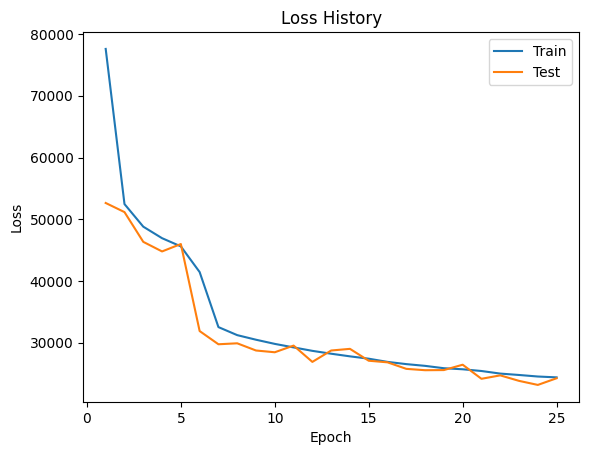

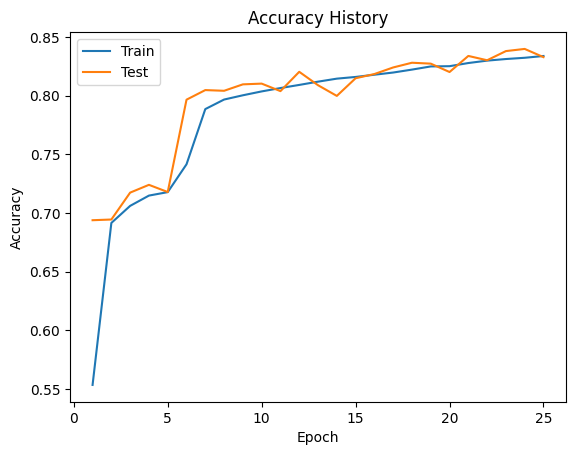

In [ ]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [ ]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.83285


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

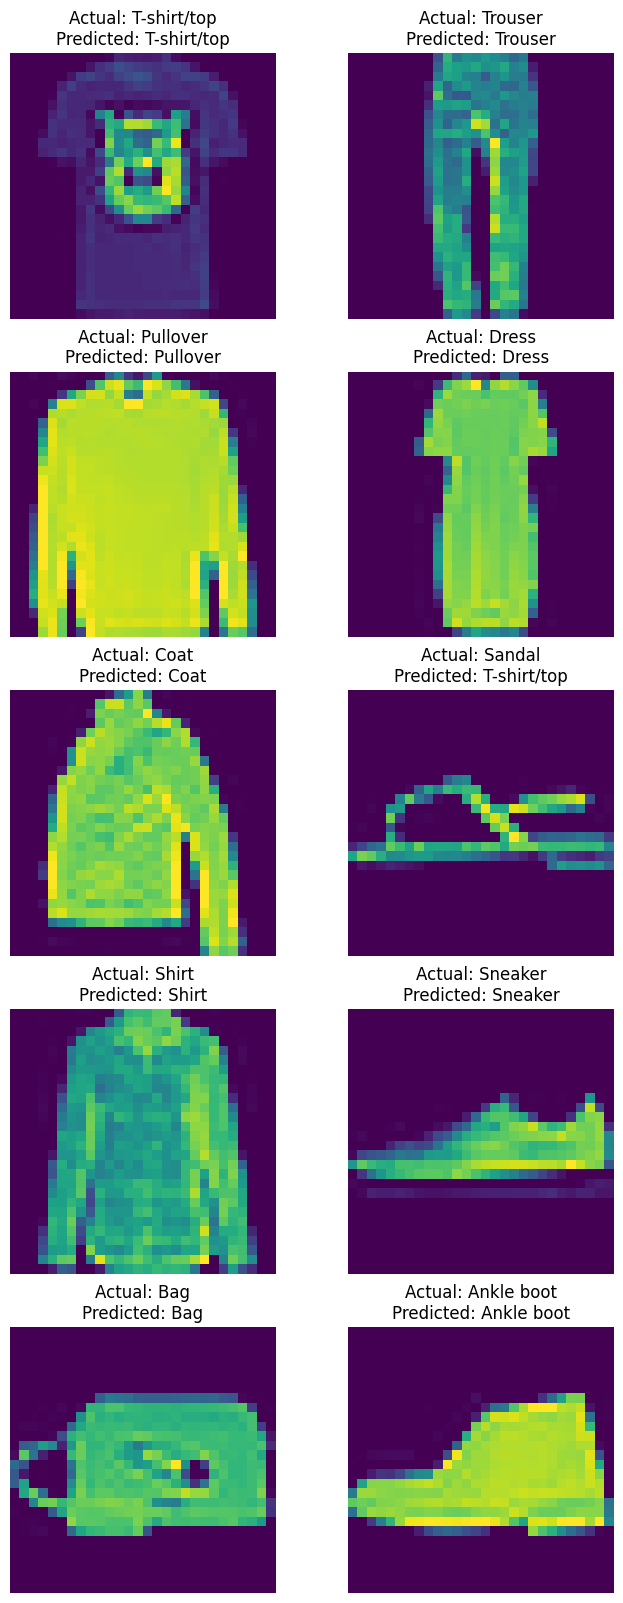

In [ ]:
## FILL HERE

validation_images = []

for class_name in class_names:
    class_indices = np.where(test_set.targets == class_names.index(class_name))[0]
    random_index = np.random.randint(len(class_indices))
    image, label = test_set[class_indices[random_index]]
    validation_images.append((image, label))


plt.figure(figsize=(8, 20))

for i, (image, label) in enumerate(validation_images):
    image_np = np.transpose(image,(1, 2, 0))
    class_name = class_names[label]
    p = model(image, parameters)
    predicted_label = p.argmax(dim=-1).item()

    plt.subplot(5, 2, i + 1)
    plt.imshow(image_np)
    plt.title(f'Actual: {class_name}\nPredicted: {class_names[predicted_label]}')
    plt.axis('off')    

plt.show()